In [682]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_wine
from scipy.stats import multivariate_normal
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture

### Implementation of GMM class

In [683]:
class GMM:
    def __init__(self,n_components):
        self.n_components=n_components
        self.responsibilities=None
        self.tolerance=1e-3
    def get_membership(self):
        mem_class=np.argmax(self.responsibilities, axis=1)
        return mem_class
    def score(self):
        return self.log_likelihood
    def initialize_params(self,X):
        kmeans = KMeans(n_clusters=self.n_components,random_state=0)
        kmeans.fit(X)
        self.means = kmeans.cluster_centers_
        # self.covariances = [np.cov(X.T) for _ in range(self.n_components)]
        # print(self.covariances[0].shape)
        # for k in range(self.n_components):
        #     for i in range(X.shape[1]):
        #         for j in range(X.shape[1]):
        #             if i!=j:
        #                 self.covariances[k][i][j]=0
        # random_indices = np.random.choice(X.shape[0], self.n_components, replace=False)
        # self.means = X[[i for i in range(self.n_components)]]
        self.covariances = [np.eye(X.shape[1]) for _ in range(self.n_components)]
        self.weights = np.bincount(kmeans.labels_)/ self.n_components
    def Estep(self,X):
        responsibilities = np.zeros((X.shape[0], self.n_components))
        # n_features=X.shape[1]
        # for i in range(self.n_components):
        #     inv=np.linalg.inv(self.covariances[i])
        #     det = np.linalg.det(self.covariances[i])
        #     mean=self.means[i]
        #     for j in range(X.shape[0]):
        #         x=X[j]
        #         diff=x-mean
        #         pdf=(
        #             1 / (((2 * np.pi) ** (n_features / 2)) * np.sqrt(det))
        #         ) * np.exp(-0.5 * ((diff@inv)@diff))
        #         responsibilities[j, i] = pdf * self.weights[i]
        for i in range(self.n_components):
            pdf = multivariate_normal.pdf(X, mean=self.means[i], cov=self.covariances[i])
            responsibilities[:, i] = pdf * self.weights[i]
        responsibilities /= np.sum(responsibilities, axis=1, keepdims=True)
        self.responsibilities=responsibilities
    def Mstep(self,X):
        n_samples, n_features = X.shape
        for i in range(self.n_components):
            total_resp_i = np.sum(self.responsibilities[:, i])
            self.means[i] = np.sum(X * self.responsibilities[:, i][:, np.newaxis], axis=0) / total_resp_i
            diff = X - self.means[i]
            self.covariances[i]=np.dot((diff * self.responsibilities[:, i][:, np.newaxis]).T, diff) / total_resp_i
            self.weights[i] = total_resp_i / n_samples
        self.covariances+=1e-6*np.identity(n_features)
    def calculate_log_likelihood(self,X):
        responsibilities = np.zeros((X.shape[0], self.n_components))
        # n_features=X.shape[1]
        # for i in range(self.n_components):
        #     inv=np.linalg.inv(self.covariances[i])
        #     det = np.linalg.det(self.covariances[i])
        #     mean=self.means[i]
        #     for j in range(X.shape[0]):
        #         x=X[j]
        #         diff=x-mean
        #         pdf=(
        #             1 / (((2 * np.pi) ** (n_features / 2)) * np.sqrt(det))
        #         ) * np.exp(-0.5 * ((diff@inv)@diff))
        #         responsibilities[j, i] = pdf * self.weights[i]
        for i in range(self.n_components):
            pdf = multivariate_normal.pdf(X, mean=self.means[i], cov=self.covariances[i])
            responsibilities[:, i] = pdf * self.weights[i]
        log_likelihood=np.sum(np.log(np.sum(responsibilities, axis=1, keepdims=True)))
        # print(log_likelihood)
        return log_likelihood
    def fit(self, X):
        self.initialize_params(X)
        self.prev_log_likelihood =-np.inf
        while True:
            self.Estep(X)
            self.Mstep(X)
            self.log_likelihood = self.calculate_log_likelihood(X)
            if abs(self.log_likelihood - self.prev_log_likelihood) < self.tolerance:
                return self.responsibilities,self.weights
            self.prev_log_likelihood = self.log_likelihood

#### Data Preprocessing

In [684]:
data=pd.read_csv('data.csv')
data=data.iloc[:,1:].values
data= data.astype(float)
col2_mean = np.mean(data[:, 2])
col2_sd=np.std(data[:,2])
data[:, 2]=(data[:, 2] - col2_mean)/col2_sd
col4_mean=np.mean(data[:,4])
col4_sd=np.std(data[:,4])
data[:, 4]=(data[:, 4] - col4_mean)/col4_sd

In [685]:
gmm = GMM(3)
resp,out=gmm.fit(data)
print(out)
mem=gmm.get_membership()
print(mem)
# gm=GaussianMixture(n_components=3,random_state=0)
# gm.fit(data)
# print("Correct : "+str(np.sum(gm.score_samples(data))))

[0.09080887 0.43203967 0.47715146]
[1 1 2 ... 2 2 2]


#### Varying Components while keeping number of clusters same

In [686]:
num_clusters=3
for i in range(2,7):
    pca=PCA(n_components=i)
    dt=pca.fit_transform(data)
    gm=GMM(num_clusters)
    gm.fit(dt)
    mem=gm.get_membership()
    score = silhouette_score(dt, mem, metric='euclidean')
    print("Number of Components :"+str(i)+", Silhouette Score: "+str(score))

Number of Components :2, Silhouette Score: 0.27565777397580776
Number of Components :3, Silhouette Score: 0.2263693414619524
Number of Components :4, Silhouette Score: 0.16282708263486545
Number of Components :5, Silhouette Score: 0.19612587646159477
Number of Components :6, Silhouette Score: 0.15591597725235623


### GMM on Wine-Dataset

In [687]:
wine_dt=load_wine()
X=wine_dt.data
Y=wine_dt.target
scalar=StandardScaler()
X=scalar.fit_transform(X)

#### Finding optimum number of clusters in GMM using AIC and BIC

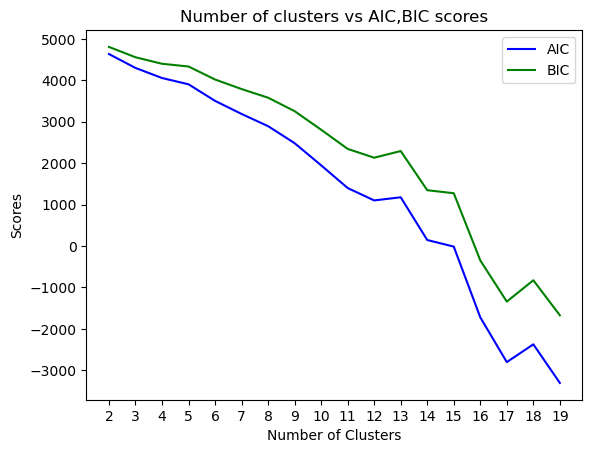

In [688]:
aic_scores=[]
bic_scores=[]
t_y=[]
n_samples, n_features = X.shape
for c in range(2,20):
    t_y.append(c)
    gm=GMM(c)
    gm.fit(X)
    # gmmm=GaussianMixture(n_components=c,random_state=0)
    # gmmm.fit(X)
    log_likelihood=gm.score()
    # log_likelihood=np.sum(gmmm.score_samples(X))
    n_params = c*(n_features*2+1)
    aic = 2 * n_params - 2 * log_likelihood
    bic = n_params * np.log(n_samples) - 2 * log_likelihood
    aic_scores.append(aic)
    bic_scores.append(bic)
plt.plot(t_y, aic_scores, label='AIC', color='blue')
plt.plot(t_y, bic_scores, label='BIC', color='green')
plt.xlabel('Number of Clusters')
plt.ylabel('Scores')
plt.title('Number of clusters vs AIC,BIC scores')
plt.xticks(t_y)
plt.legend()
plt.show()

#### Reducing to 2 Dimensions

0.5581473461293218


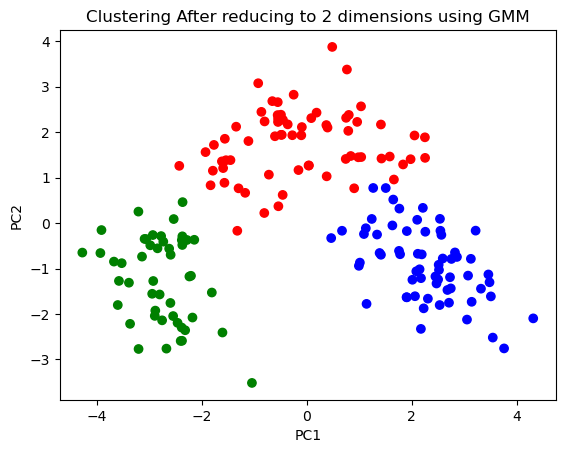

In [689]:
#GMM
pca=PCA(n_components=2)
X_new=pca.fit_transform(X)
gmm=GMM(3)
gmm.fit(X_new)
mem=gmm.get_membership()
score = silhouette_score(X_new, mem, metric='euclidean')
print(score)
color_mapping = {0: 'red', 1: 'blue', 2: 'green', 3: 'orange', 4: 'yellow'}
plt.scatter(X_new[:,0], X_new[:,1], c=[color_mapping[c] for c in mem], label=mem)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Clustering After reducing to 2 dimensions using GMM')
plt.show()

0.5610505693103245


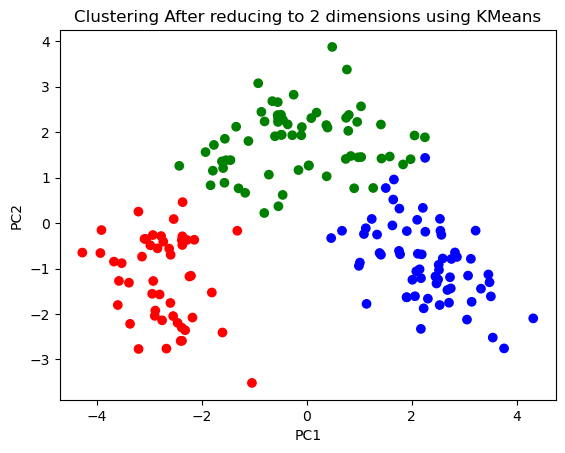

In [690]:
#KMeans
pca=PCA(n_components=2)
X_new=pca.fit_transform(X)
kmeans=KMeans(n_clusters=3)
kmeans.fit(X_new)
mem=kmeans.labels_
score = silhouette_score(X_new, mem, metric='euclidean')
print(score)
color_mapping = {0: 'red', 1: 'blue', 2: 'green', 3: 'orange', 4: 'yellow'}
plt.scatter(X_new[:,0], X_new[:,1], c=[color_mapping[c] for c in mem], label=mem)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Clustering After reducing to 2 dimensions using KMeans')
plt.show()

#### Observations: Both GMM and KMeans clustering give similar clusters when number of clusters is 3. The silhouette scores for GMM very close to that of KMeans for 3 clusters. A value of silhouette score close to 1 means indicates good clustering. For higher number of clusters, KMeans gives a better score than GMM. However, 3 seems to be the best choice for clusters as it gives the highest silhouette scores for both types of clustering.